In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

## The Upper Confidence Bound (UCB) Algorithm

As we've seen, Epsilon-Greedy has linear regret. It continues to explore the set of all actions, long after it has gained sufficient knowledge to know which of these actions are bad actions to take.

A better approach, in terms of maximising the total reward, would be to restrict the sampling over time, to the actions showing the best performance. This is the exact approach taken by the Upper Confidence Bound (UCB) strategy.

Rather than performing exploration by simply selecting an arbitrary action, chosen with a probability that remains constant, the UCB algorithm changes its exploration-exploitation balance as it gathers more knowledge of the environment. It moves from being primarily focused on exploration, when actions that have been tried the least are preferred, to instead concentrate on exploitation, selecting the action with the highest estimated reward.

With UCB, 'Aₜ', the action chosen at time step 't', is given by:


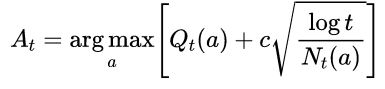


where;
Qₜ(a) is the estimated value of action 'a' at time step 't'.
Nₜ(a) is the number of times that action 'a' has been selected, prior to time 't'.
'c' is a constant, whose role will be described shortly.



The formula for UCB can be thought of as being formed from 2 distinct parts:

* Qₜ(a) represents the exploitation part of the equation. UCB is based on the principle of "optimism in the fact of uncertainty", which basically means, if you don't know which action is best then choose the one that currently looks to be the best. Taking this half of the equation by itself will do exactly that: the action that currently has the highest estimated reward will be the chosen action.


* The second half of the equation adds exploration, with the degree of exploration being controlled by the hyper-parameter 'c'. Effectively this half of the equation provides a measure of the uncertainty for the action's reward estimate.
If an action hasn't been tried very often, or not at all, then Nₜ(a) will be small. Consequently the uncertainty term will be large, making this action more likely to be selected. Every time an action is taken we become more confident about its estimate. In this case Nₜ(a) increments, and so the uncertainty term decreases, making it less likely that this action will be selected as a result of exploration (although it may still be selected as the action with the highest value, due to the exploitation term).
When an action is not being selected, the uncertainty term will grow slowly, due to the log function in the numerator. Whereas, every time that the action is selected, the uncertainty will shrink rapidly due to the increase in Nₜ(a) being linear. So the exploration term will be larger for actions that have been selected infrequently, due to the uncertainty in the estimates of their rewards.
As time progresses the exploration term gradually decreases (since as 'n' goes to infinity log n/n goes to zero), until eventually actions are selected based only on the exploitation term.

The relative contributions of each of the exploration and exploitation terms can be seen in the graph below. Here, to simplify the comparison, we've taken only the first 2 sockets from our standard set. These 2 sockets have mean reward values of 6 and 4 seconds of charge respectively and it can be seen as time progresses that the estimate of the reward (the Q value, shown by the shaded bars) converges on this value for each socket.

But the UCB formula also contains the uncertainty term, represented by the solid part of the bar for each socket, and the socket that gets selected is the one with the maximum value of Q plus this uncertainty term. So, on the graph, at each time step, the socket that will be selected is the one with tallest bar.

In [2]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):    
        """ initialize the UCB socket """                  
        
        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)       
                
        # pass the true reward value to the base PowerSocket   
        super().__init__(q)           
        
    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 
        

In [3]:
class UCBSocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, confidence_level=2.0 ):                  
        """ initialize the socket tester """                  
        super().__init__(socket = UCBSocket, 
                         socket_order = socket_order, 
                         confidence_level = confidence_level, 
                         number_of_stats = 3) # a UCB socket tester records 3 bits of information over a run
        
    def get_socket_stats( self, t ):
        """ record the current values of each socket """
        socket_stats = [[socket.Q,socket.n,socket.uncertainty(t+1)] for socket in self.sockets]
        return socket_stats   

    def select_socket( self, t ):
        """ choose the socket with the current highest UCB reward """
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])     
        return socket_index        

In [4]:
# do a single run with only 2 sockets to examine how the exploration and exploitation terms of the UCB equation vary
number_of_sockets = 2
number_of_steps = 20

# set the random seed to produce a recreatable graph
random.seed(0) 
np.random.seed(0)

tester = UCBSocketTester( socket_order[:number_of_sockets], confidence_level = 3.0 )
tester.run( number_of_steps )

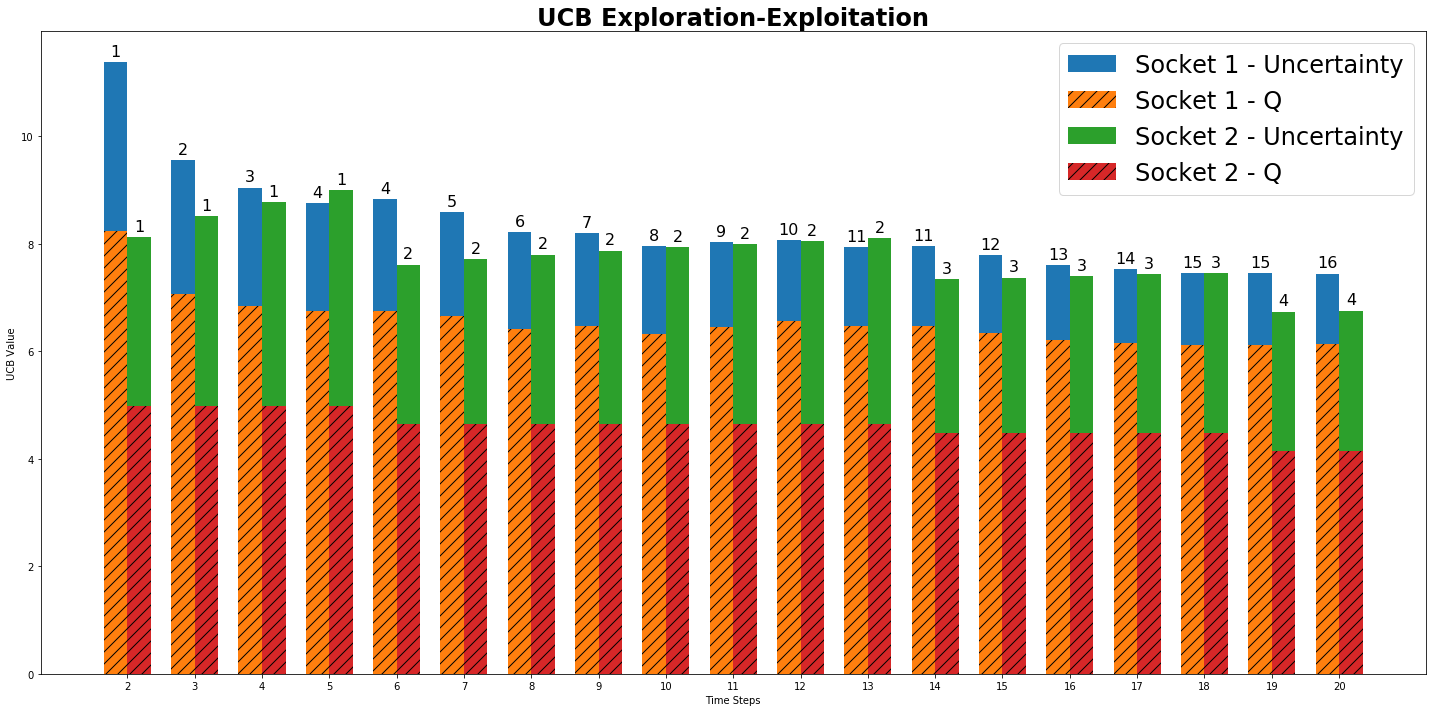

In [5]:
# get the parameters to graph from the socket stats
estimates = tester.socket_stats[:,:,0]
trials = tester.socket_stats[:,:,1]
uncertainty = tester.socket_stats[:,:,2]

x = np.arange(len(estimates[:,0]))[2:]  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

rects1 = [ plt.bar(x, uncertainty[2:,0]+estimates[2:,0], align='edge', width= -width, label='Socket 1 - Uncertainty'),
           plt.bar(x, estimates[2:,0], align='edge', width= -width, label='Socket 1 - Q', hatch='//')]

rects2 = [ plt.bar(x, uncertainty[2:,1]+estimates[2:,1], align='edge',width= width, label='Socket 2 - Uncertainty'),
           plt.bar(x, estimates[2:,1], align='edge',width= width, label='Socket 2 - Q', hatch='//')]

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('UCB Value')
ax.set_xlabel('Time Steps')
ax.set_title('UCB Exploration-Exploitation', fontsize=24, fontweight='bold')
ax.legend(fontsize=24)
ax.set_xticks(x)


def autolabel(rects,index,trials):
    """Attach a text label above each bar in *rects*, displaying its number of trials"""

    for i,rect in enumerate(rects[0]):
        height = rect.get_height()
        ax.annotate('{:.0f}'.format(trials[i+2,index]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    size=16,
                    ha='center', va='bottom')  


autolabel(rects1,0,trials)
autolabel(rects2,1,trials)

fig.tight_layout()

plt.savefig('ucb_exploration_exploitation.png')
plt.show()

So the points to note from the graph are as follows:

* An initial priming step is performed, which tries each action once to get its initial value. This then avoids divide-by-zero errors in the exploration term when actions have not yet been tried and Nₜ(a) is equal to zero. Obviously this is only applicable when there are fewer possible actions 'k' than there are time steps 't', otherwise there wouldn't be enough time to try every action.


* Due to the priming round the graph begins at time step 2. The number of times that each socket has been selected is shown by the number at the top of each bar. So, at time step 2, it can be seen that each socket has been selected once. Since each socket has been tried the same number of times the contribution of the uncertainty term is the same for each socket. However, due to its larger reward estimate 'Q', socket 1 has the largest total UCB value and is therefore selected by the argmax function.


* At time step 3, socket 1 was the selected socket at the previous time step, so the count of the number of times it has been tried increases to 2. As a result the uncertainty term for this socket shrinks, so the solid blue bar can be seen to decrease in size. The hatched yellow bar also decreases due to this socket having been sampled and forming a better estimate for the true socket reward.
On the other hand, socket 2 wasn't selected, so its reward estimate stays the same. The number of times it has been selected also stays the same, while the number of time steps increases, consequently the size of its uncertainty term increases, so the solid green bar can be seen to get bigger.
However, the overall size of the UCB term for socket 1 is still greater than that of socket 2, so once again it is the socket that gets selected.


* Eventually, at time step 5, socket 2's uncertainty term has increased sufficiently to make its total UCB value greater than that of socket 1 and so it is the socket that gets chosen. Once this happens its estimated reward value moves closer to the true mean reward, its uncertainty term shrinks and the whole process begins again.

In [21]:
def plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps ):

    df = pd.DataFrame(socket_percentages)
    for socket in range(df.shape[1]):
        plt.plot(confidence_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

    plt.plot(confidence_values, np.ones(df.shape[0])*20,'k')

    plt.legend(title = 'Sockets')
    plt.title('Socket Selection Percentage vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Socket Selection (%)')
     
def plot_ucb_final_socket_estimates( confidence_values, final_socket_estimates, number_of_steps ):    
    df = pd.DataFrame(final_socket_estimates)
    for socket in range(df.shape[1]):
        plt.plot(confidence_values, df[socket], label = f'{socket+1}', marker='o', linestyle='--')           

    plt.legend(title = 'Sockets')
    plt.title('Final Socket Estimate vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Final Socket Estimate')    
    
def plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps, figsize=(10,8) ):
    
    plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
    plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
    plt.xlabel('Confidence Level')
    plt.ylabel('Mean Total Reward per Time Step')  
    
    
def plot_ucb(confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates, number_of_steps ):
    fig = plt.figure(figsize=(26,5))

    plt.suptitle(f'Upper Confidence Bound: {number_of_steps} time-steps per run', fontsize=20, fontweight='bold')

    plt.subplot(1, 3, 1)
    plot_ucb_socket_percentages( confidence_values, socket_percentages, number_of_steps )

    plt.subplot(1, 3, 2)
    plot_ucb_reward_per_timestep( confidence_values, reward_per_timestep, number_of_steps )

    plt.subplot(1, 3, 3)
    plot_ucb_final_socket_estimates( confidence_values, final_socket_estimates, number_of_steps )

    plt.savefig(f"ucb_{number_of_steps}.png")

    plt.show()   

In [18]:
def ucb_experiment( number_of_tests, number_of_steps, confidence_level = 3.0):    
    
    experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = confidence_level ),
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps)
    experiment.run()
    
    return experiment.get_estimates(),\
           experiment.get_mean_total_reward(),\
           experiment.get_optimal_selected(),\
           experiment.get_socket_percentages()

In [19]:
def run_ucb_experiment( start, end, step = 0.01, number_of_tests = 100, number_of_steps = 300 ):     

    test_values = []
    reward_per_timestep = []
    optimal_selected = []
    socket_percentages = []
    final_socket_estimates = []
        
    # iterate over the confidence level values
    for confidence_level in tqdm( np.arange( start, (end+step), step ) ):
        
        # save the test value used to run this test
        test_values.append( confidence_level )               
        
        mean_estimates, mean_reward_per_timestep, mean_optimal_selected, mean_socket_percentage = ucb_experiment( number_of_tests, number_of_steps, confidence_level )                           
                
        reward_per_timestep.append( mean_reward_per_timestep )
        optimal_selected.append( mean_optimal_selected )
        socket_percentages.append( mean_socket_percentage ) 
        final_socket_estimates.append( mean_estimates[-1] )
     
    return test_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates          

In [46]:
# how many times each test should be run
number_of_tests = 500

# the confidence level test range
start = 0
stop = 100.0
step = 5

number_of_steps = 100
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )  

100%|██████████| 21/21 [02:02<00:00,  5.85s/it]


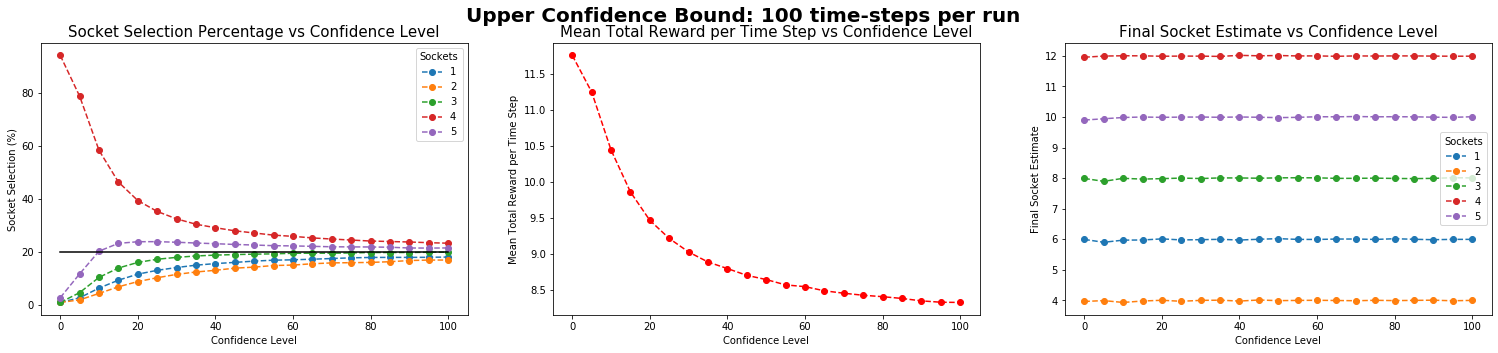

In [47]:
plot_ucb(confidence_values, 
         reward_per_timestep, 
         optimal_selected, 
         socket_percentages, 
         final_socket_estimates, 
         number_of_steps )

In [43]:
# how many times each test should be run
number_of_tests = 1000

# the confidence level test range
start = 0.
stop = 2.0
step = 0.1

number_of_steps = 50
confidence_values, reward_per_timestep, optimal_selected, socket_percentages, final_socket_estimates = \
    run_ucb_experiment( start, stop, step, number_of_tests, number_of_steps )  

100%|██████████| 21/21 [02:01<00:00,  5.77s/it]


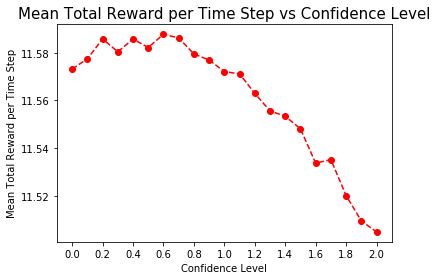

In [45]:
plt.xticks(np.arange(0., 2.2, 0.2))
plt.plot( confidence_values, reward_per_timestep, marker='o', linestyle='--', color='r') 
plt.title('Mean Total Reward per Time Step vs Confidence Level', fontsize=15)
plt.xlabel('Confidence Level')
plt.ylabel('Mean Total Reward per Time Step') 
plt.savefig(f"ucb_reward_per_timestep{number_of_steps}.png")

In [48]:
# create and test UCB sockets
tester = UCBSocketTester( confidence_level = 0.6)
tester.run( number_of_steps = 1000 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage()}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 11.986267664583197
Optimal Socket Selected = 0.996
Socket Percentages = [0.001 0.001 0.001 0.996 0.001]


In [49]:
# run the test 100 times with each test running for 1000 timesteps
number_of_tests = 100
number_of_steps = 1000    

experiment = SocketExperiment(socket_tester   = UCBSocketTester( confidence_level = 0.6 ),
                              number_of_tests = number_of_tests,
                              number_of_steps = number_of_steps)
experiment.run()

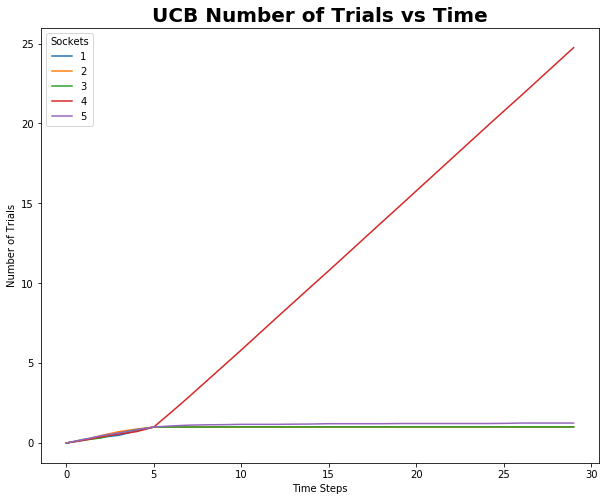

In [50]:
number_of_trials = experiment.get_number_of_trials()

plt.figure(figsize=(10,8))
for socket in range(number_of_trials.shape[1]):
    plt.plot(number_of_trials[:30,socket], label = f'{socket+1}')  
    
plt.title('UCB Number of Trials vs Time', fontsize=20, fontweight='bold')
plt.legend(title = 'Sockets')
plt.xlabel('Time Steps')
plt.ylabel('Number of Trials')

plt.savefig("UCB_number_of_trials.png")    

## Regret

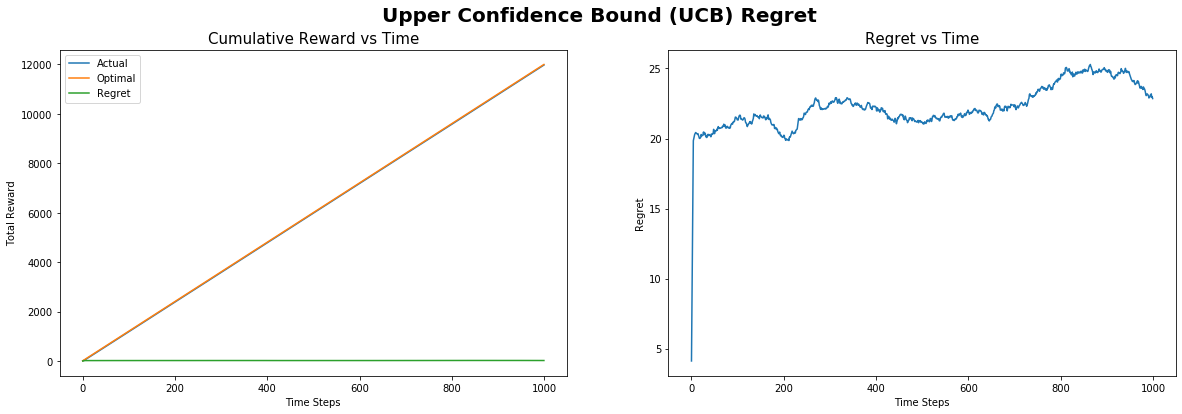

In [51]:
# best socket has a true mean reward of 12
cummulative_optimal_reward = [r*12 for r in range(1,number_of_steps+1)]

# regret is the difference between the optimal reward and the actual reward 
regret = cummulative_optimal_reward - experiment.get_cumulative_reward_per_timestep()


fig = plt.figure(figsize=(20,6))
plt.suptitle(f'Upper Confidence Bound (UCB) Regret', fontsize=20, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(experiment.get_cumulative_reward_per_timestep(),label = "Actual")
plt.plot(cummulative_optimal_reward, label ="Optimal")
plt.plot(regret, label ="Regret")
plt.legend()
plt.title('Cumulative Reward vs Time', fontsize=15)
plt.xlabel('Time Steps')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.title('Regret vs Time', fontsize=15)
plt.plot(regret)
plt.xlabel('Time Steps')
plt.ylabel('Regret')

plt.savefig(f"ucb_regret.png")
plt.show()  